In [56]:
import math, random
import os, json
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [57]:
ART = "artifacts"
CANDIDATES = '/Users/user/data/research/proton-deuteron/ssvd/deuteron_candidates_clean.pkl'
OUT_CSV  = "deuteron_scores.csv"

In [58]:
IMG_H, IMG_W = 64, 96
BATCH_SIZE   = 256
FEAT_DIM     = 128

In [59]:
class DeutNet(nn.Module):
    def __init__(self, in_ch=2, feat_dim=FEAT_DIM):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, 16, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), nn.ReLU()
        )
        self.fc = nn.Linear(64, feat_dim)

    def forward(self, x):
        x = self.conv(x)
        x = F.adaptive_avg_pool2d(x, 1).flatten(1)
        return self.fc(x)

In [60]:
class CandidateDS(Dataset):
    def __init__(self, df, global_max_adc):
        self.df = df.reset_index(drop=True)
        self.gmax = float(global_max_adc)

    def __len__(self):
        return len(self.df)
    
    def _to_fixed(self, img):
        h, w, = img.shape
        out = np.zeros((IMG_H, IMG_W), dtype=np.float32)
        h0 = min(h, IMG_H)
        w0 = min(w, IMG_W)
        out[:h0, :w0] = img[:h0, :w0]
        return out
    
    def __getitem__(self, i):
        arr = np.asarray(self.df.loc[i, 'image_intensity'], dtype=np.float32)
        x = self._to_fixed(arr)

        ch0 = x / (self.gmax + 1e-6)
        
        mu, sd = float(x.mean()), float(x.std())
        if sd < 1e-6: sd = 1e-6
        ch1 = (x - mu) / sd

        x2 = np.stack([ch0, ch1], axis=0)                                           # (2, H, W)

        return torch.from_numpy(x2), i

In [70]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print('Device:', device)

with open(os.path.join(ART, 'threshold.json')) as f:
    meta = json.load(f)

global_max_adc = float(meta['global_max_adc'])
thr = float(meta['threshold'])

centre = torch.from_numpy(np.load(os.path.join(ART, 'centre.npy'))).float().to(device)

print('Loading candidates:', CANDIDATES)
df = pd.read_pickle(CANDIDATES)
n = len(df)
print('Rows:', n)

ds = CandidateDS(df, global_max_adc)
dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

Device: mps
Loading candidates: /Users/user/data/research/proton-deuteron/ssvd/deuteron_candidates_clean.pkl
Rows: 4544


In [71]:
model = DeutNet().to(device)
sd = torch.load(os.path.join(ART, 'svdd.pt'), map_location=device)
model.load_state_dict(sd)
model.eval()

DeutNet(
  (conv): Sequential(
    (0): Conv2d(2, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc): Linear(in_features=64, out_features=128, bias=True)
)

In [72]:
scores = np.zeros(n, dtype=np.float32)

with torch.no_grad():
    for batch, idxs in tqdm(dl, total=math.ceil(n / BATCH_SIZE)):
        batch = batch.to(device, non_blocking=True)
        d = torch.norm(model(batch) - centre, dim=1).cpu().numpy()
        scores[idxs.numpy()] = d

  0%|          | 0/18 [00:00<?, ?it/s]/Users/user/code/research/proton-deuteron/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
100%|██████████| 18/18 [00:00<00:00, 55.71it/s]


In [73]:
cols = ["event_idx","run","subrun","event","cluster_idx"]
cols = [c for c in cols if c in df.columns]
out = df[cols].copy() if cols else pd.DataFrame(index=df.index)
out["svdd_distance"] = scores
out["is_deuteron_pred"] = out["svdd_distance"] <= thr

out.to_csv(OUT_CSV, index=False)
print('Wrote:', OUT_CSV)

Wrote: deuteron_scores.csv


In [74]:
num_below_threshold = np.sum(scores <= thr)
num_below_threshold

np.int64(896)

In [66]:
thr = 0.0062

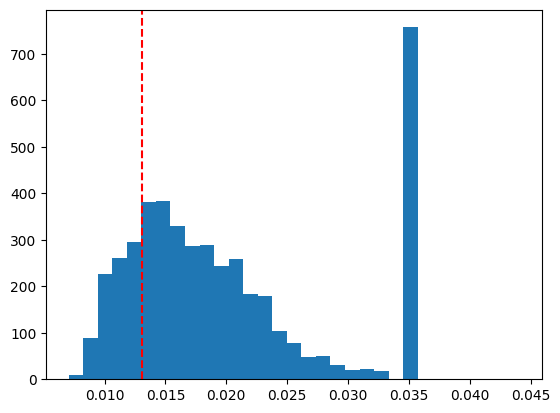

In [75]:
plt.hist(out['svdd_distance'], bins='auto')
plt.axvline(thr, ls="--", lw=1.5, color='r', label='Threshold')

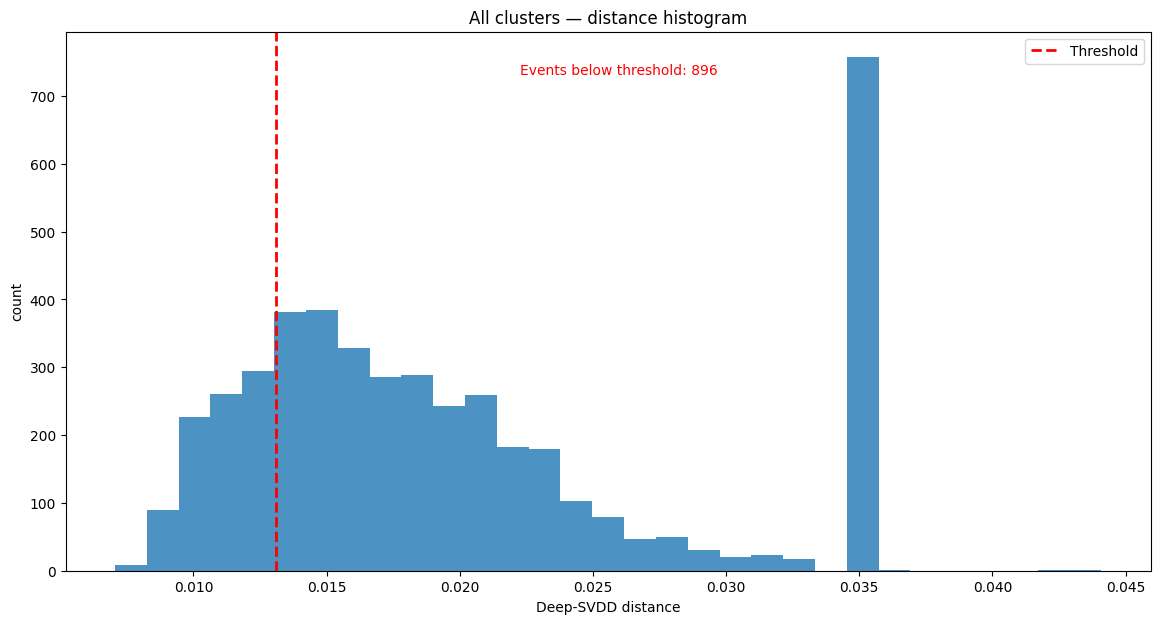

In [76]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# If df is already in memory with the column "score"
scores = out["svdd_distance"].astype(float).values

# bins = np.linspace(scores.min(), np.percentile(scores, 99.9), 200)
num_below_threshold = np.sum(scores <= thr)

plt.figure(figsize=(14,7))
plt.hist(scores, bins='auto', alpha=0.8)
plt.axvline(thr, ls="--", lw=2, color='r', label='Threshold')
plt.xlabel("Deep-SVDD distance")
plt.ylabel("count")
plt.title("All clusters — distance histogram")
plt.legend()

plt.text(thr * 1.7, plt.ylim()[1] * 0.92, f"Events below threshold: {num_below_threshold}", color='red', fontsize=10)
plt.show()

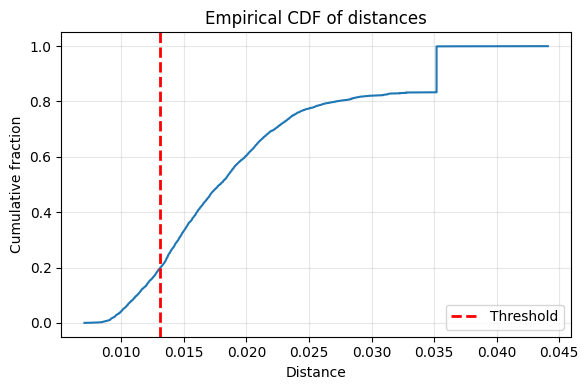

In [77]:
s = np.sort(scores)
y = np.linspace(0, 1, len(s), endpoint=False)

plt.figure(figsize=(6,4))
plt.plot(s, y)
plt.axvline(thr, ls="--", lw=2, color='r', label='Threshold')
plt.xlabel("Distance"); plt.ylabel("Cumulative fraction")
plt.title("Empirical CDF of distances")
plt.legend()
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

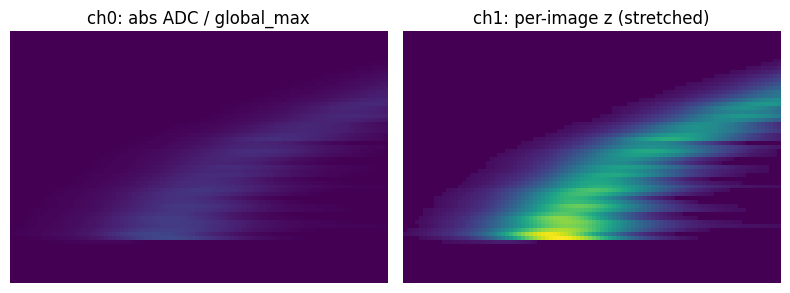

In [261]:
i = random.randint(0, len(ds))  
x = ds[i]                 # shape: (2, H, W), on CPU
ch0 = x[0][0].numpy()
ch1 = x[0][1].numpy()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Channel 0: scaled absolute ADC
axs[0].imshow(ch0, vmin=0.0, vmax=1.0)
axs[0].set_title("ch0: abs ADC / global_max")
axs[0].axis("off")

# Channel 1: z-score (stretch to [0,1] for display only)
z = ch1
z_disp = (z - z.min()) / (z.max() - z.min() + 1e-6)
axs[1].imshow(z_disp)
axs[1].set_title("ch1: per-image z (stretched)")
axs[1].axis("off")

plt.tight_layout()
plt.show()